In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random


In [2]:
data_source = pd.read_csv('data_source.csv')
#data_source = data_source[data_source['label']=='153 - Input Data Manipulation']
data_target  = pd.read_csv('data_target.csv')
data_target = data_target.sample(frac=1, random_state=42)
#data_target = data_target[data_target['label']=='153 - Input Data Manipulation']
X_source = data_source['text'].str.replace('/',' ')
y_source = data_source['label']
X_target  = data_target ['text'].str.replace('/','')
y_target  = data_target ['label']
rlist =['194 - Fake the Source of Data', '66 - SQL Injection',
       '34 - HTTP Response Splitting', '126 - Path Traversal',
       '000 - Normal', '272 - Protocol Manipulation',
       '310 - Scanning for Vulnerable Software', '242 - Code Injection',
       '153 - Input Data Manipulation']
mapping = {l: i+1 for i, l in enumerate(rlist)}
y_source = [mapping[s] for s in y_source] 
y_target  = [mapping[r] for r in y_target ]
y_source = np.array(y_source)
y_target  = np.array(y_target )


In [3]:
mapping

{'194 - Fake the Source of Data': 1,
 '66 - SQL Injection': 2,
 '34 - HTTP Response Splitting': 3,
 '126 - Path Traversal': 4,
 '000 - Normal': 5,
 '272 - Protocol Manipulation': 6,
 '310 - Scanning for Vulnerable Software': 7,
 '242 - Code Injection': 8,
 '153 - Input Data Manipulation': 9}

In [4]:
y_target = np.where(np.logical_or(y_target == 8, y_target == 9), 0, 1)

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import json


class Vectorizer:
    def __init__(self, method='BOW', ngram_range=(1, 1), max_features=300, emb_fname='', word_index_fname=''):
        self.method = method
        if self.method == 'BOW':
            self.vectorizer = CountVectorizer(analyzer='word', input='content', ngram_range=ngram_range, max_features=max_features)
        elif self.method == 'TFIDF':
            self.vectorizer = TfidfVectorizer(analyzer='word', input='content', max_features=max_features)
        elif self.method == 'Word2Vec':
            self.max_features = max_features
            self.emb_fname = emb_fname
            self.word_index_fname = word_index_fname
        else:
            raise ValueError('Feature extraction method does not exist.')

    def feature_extraction(self, X_train, X_test):
        train_data = self.vectorizer.fit_transform(X_train).toarray()
        test_data = self.vectorizer.transform(X_test).toarray()
        return train_data, test_data

    def get_word_index(self):
        word2id = json.load(open(self.word_index_fname, 'r'))
        return word2id

    def get_embedding_matrix(self):
        np.random.seed(0)
        word2id = self.get_word_index()
        embedding_matrix = np.random.uniform(-0.25, 0.25, [len(word2id) + 1, self.max_features])
        with open(self.emb_fname, 'r', encoding='utf-8') as f:
            for line in f:
                content = line.split(' ')
                if content[0] in word2id:
                    embedding_matrix[word2id[content[0]]] = np.array(list(map(float, content[1:])))
        return embedding_matrix

In [6]:
# vectorizer = Vectorizer('TFIDF')
# X_train, X_test = vectorizer.feature_extraction(X_source, X_target)

In [7]:
from gensim.models import Word2Vec
sentences = [sentence.split() for sentence in X_source]
w2v_model = Word2Vec(sentences, window=5, min_count=5, workers=4)

In [8]:
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train = np.array([vectorize(sentence) for sentence in X_source])
X_test = np.array([vectorize(sentence) for sentence in X_target])

In [9]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [10]:
input_layer = X_train.shape[1]

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_layer, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), input_layer)
        output = self.model(x)
        return output

In [12]:
discriminator = Discriminator().to(device=device)

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_layer, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_layer),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), input_layer)
        return output

generator = Generator().to(device=device)

In [14]:
lr = 0.00001
num_epochs = 1000
batch_size= 32
loss_function = nn.BCELoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [15]:
X_source = torch.from_numpy(X_train).to(device=device, dtype=torch.float32)
X_target = torch.from_numpy(X_test).to(device=device, dtype=torch.float32)

In [16]:
for epoch in range(num_epochs):
    idx = np.random.randint(0, X_source.shape[0], batch_size)
    real_samples  = X_source[idx]
    real_samples_labels = torch.ones((batch_size,1)).to(device=device)
    latent_space_samples = torch.rand((batch_size,input_layer)).to( device=device)
    
    generated_samples = generator(latent_space_samples)
    generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
    all_samples = torch.cat((real_samples, generated_samples))
    all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
    discriminator.zero_grad()
    output_discriminator = discriminator(all_samples)
    loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
    loss_discriminator.backward()
    optimizer_discriminator.step()

        # Data for training the generator
    latent_space_samples = torch.rand((batch_size,input_layer)).to(device=device)

        # Training the generator
    generator.zero_grad()
    generated_samples = generator(latent_space_samples)
    output_discriminator_generated = discriminator(generated_samples)
    loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
    loss_generator.backward()
    optimizer_generator.step()
    if(epoch%100==0):
        print(f"Epoch: {epoch/100} Loss D.: {loss_discriminator}")
        print(f"Epoch: {epoch/100} Loss G.: {loss_generator}")
 

Epoch: 0.0 Loss D.: 0.694198727607727
Epoch: 0.0 Loss G.: 0.6680736541748047
Epoch: 1.0 Loss D.: 0.6211839914321899
Epoch: 1.0 Loss G.: 0.6581594347953796
Epoch: 2.0 Loss D.: 0.6264723539352417
Epoch: 2.0 Loss G.: 0.5679495930671692
Epoch: 3.0 Loss D.: 0.5814388990402222
Epoch: 3.0 Loss G.: 0.7234567403793335
Epoch: 4.0 Loss D.: 0.6028750538825989
Epoch: 4.0 Loss G.: 0.7514563202857971
Epoch: 5.0 Loss D.: 0.5338872671127319
Epoch: 5.0 Loss G.: 0.7741644382476807
Epoch: 6.0 Loss D.: 0.4924606382846832
Epoch: 6.0 Loss G.: 0.785311222076416
Epoch: 7.0 Loss D.: 0.5157299637794495
Epoch: 7.0 Loss G.: 0.8946226835250854
Epoch: 8.0 Loss D.: 0.4489753246307373
Epoch: 8.0 Loss G.: 1.0600844621658325
Epoch: 9.0 Loss D.: 0.4402088224887848
Epoch: 9.0 Loss G.: 0.9925678968429565


In [17]:
predicted_labels = discriminator(X_target)
new_tensor = torch.where(predicted_labels >= 0.5, torch.tensor(1), torch.tensor(0))

In [18]:
new_label = new_tensor.numpy()

In [19]:
from sklearn.metrics import accuracy_score

In [20]:
accuracy = accuracy_score(y_target, new_label)
accuracy

0.8650885391047712

In [21]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

In [22]:
cm = confusion_matrix(y_target, new_label)

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

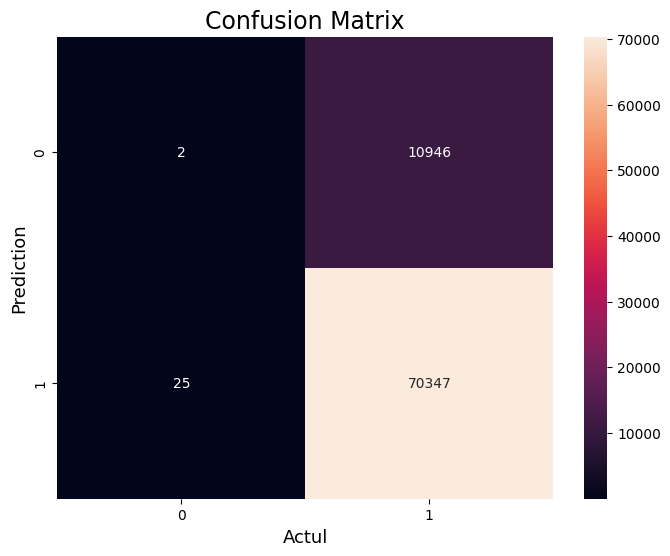

In [24]:
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt='g',xticklabels = [0,1],yticklabels= [0,1])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actul',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()